In [1]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=a062962e5e9d75797d1dc9a5108149fe18715f40faa165a76efb55582487931d
  Stored in directory: /tmp/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

from pandas_profiling import ProfileReport

import time
from apyori import apriori as apriori1

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori as apriori2
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

/kaggle/input/basket-optimisation/Market_Basket_Optimisation.csv


## Motivation
- Assocition rules
    - Support: how popular an itemset is, statistics the number of each item appears in the all transactions, i.e., frequency of item. 
    $$support(X)=\frac{occurance\  of\ item}{total\ nb\ of\ transaction}$$
    - Confidence: how likely item Y is purchased when item X is purchased, expressed as {X -> Y}
    $$confidence(X,Y)=\frac{support(X \cup Y)}{support(X)}=\frac{P(XY)}{P(X)}=P(Y|X)$$
    - Lift: This says how likely item $Y$ is purchased when item $X$ is purchased, while controlling for how popular item $Y$ is. i.e., the lift of {apple -> beer} is $1$,which implies no association between items. A lift value greater than $1$ means that item $Y$ is likely to be bought if item $X$ is bought, while a value less than $1$ means that item $Y$ is unlikely to be bought if item $X$ is bought.
    $$left(X,Y)=\frac{support(X \cup Y)}{support(X) \times support(Y)}=\frac{confidence(X,Y)}{support(Y)}=\frac{P(Y|X)}{P(Y)}$$
- Word cloud

## Model
- Apriori
- FPGrowth
- Word Frequent

## Exploratory Data Analysis (EDA)

In [3]:
data = pd.read_csv('/kaggle/input/basket-optimisation/Market_Basket_Optimisation.csv')

In [4]:
data_profile_report = ProfileReport(data, 'Data Set Profiling Report', html={'style':{'full_width':True}})

In [5]:
data_profile_report.to_notebook_iframe()

In [6]:
data.fillna(0, inplace=True)

## Association Rules

In [7]:
def get_apriori_statistics(rules):
    df = pd.DataFrame(list(rules))
    first_items = []
    second_items = []
    support = []
    confidence = []
    lift = []
    for i in range(df.shape[0]):
        for idx, order_stat in enumerate(df['ordered_statistics'][i]):
            if idx == 0:
                sup = df['support'][i]
                continue
            first_items.append(str(list(order_stat[0])).lstrip("['").rstrip("']"))
            second_items.append(str(list(order_stat[1])).lstrip("['").rstrip("']"))
            support.append(sup)
            confidence.append(order_stat[2])
            lift.append(order_stat[3])
    fitems = pd.DataFrame(first_items, columns=['item1'])
    sitems = pd.DataFrame(second_items, columns=['item2'])
    dsupport = pd.DataFrame(support, columns=['support'])
    dconfidence = pd.DataFrame(confidence, columns=['confidance'])
    dlift = pd.DataFrame(lift, columns=['lift'])
    return pd.concat([fitems, sitems, dsupport, dconfidence, dlift], axis=1)

In [8]:
def get_transactions(df):
    transactions = []
    for i in range(0, len(df)):
        transactions.append([df.iloc[i,j] for j in range(0, df.shape[1]) if df.iloc[i,j] != 0])
    return transactions

### Package apyori

In [9]:
now = time.time()
rules = apriori1(get_transactions(data), min_support=0.003, min_confidance=0.2, min_left=3)
print(time.time() - now)

3.3963115215301514


In [10]:
get_apriori_statistics(rules)

,item1,item2,support,confidance,lift
0,almonds,burgers,0.005200,0.256579,2.942419
1,burgers,almonds,0.005200,0.059633,2.942419
2,almonds,cake,0.003067,0.151316,1.866560
3,cake,almonds,0.003067,0.037829,1.866560
4,almonds,chocolate,0.006000,0.296053,1.806668
...,...,...,...,...,...
5121,"spaghetti', 'tomatoes","milk', 'mineral water",0.003333,0.159236,3.317410
5122,"milk', 'spaghetti', 'mineral water",tomatoes,0.003333,0.211864,3.097433
5123,"milk', 'tomatoes', 'mineral water",spaghetti,0.003333,0.510204,2.929962
5124,"milk', 'spaghetti', 'tomatoes",mineral water,0.003333,0.568182,2.384647


### Package mlxtend

In [11]:
te = TransactionEncoder()
te_ary = te.fit_transform(get_transactions(data))
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori2(df, min_support=0.003, use_colnames=True)

In [12]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(almonds),(burgers),0.020267,0.087200,0.005200,0.256579,2.942419,0.003433,1.227837
1,(almonds),(chocolate),0.020267,0.163867,0.006000,0.296053,1.806668,0.002679,1.187778
2,(almonds),(eggs),0.020267,0.179733,0.006533,0.322368,1.793593,0.002891,1.210491
3,(almonds),(french fries),0.020267,0.170933,0.004400,0.217105,1.270117,0.000936,1.058976
4,(almonds),(green tea),0.020267,0.132000,0.004933,0.243421,1.844099,0.002258,1.147270
...,...,...,...,...,...,...,...,...,...
1357,"(milk, spaghetti, tomatoes)",(mineral water),0.005867,0.238267,0.003333,0.568182,2.384647,0.001936,1.764014
1358,"(milk, spaghetti, mineral water)",(tomatoes),0.015733,0.068400,0.003333,0.211864,3.097433,0.002257,1.182030
1359,"(milk, tomatoes, mineral water)",(spaghetti),0.006533,0.174133,0.003333,0.510204,2.929962,0.002196,1.686144
1360,"(spaghetti, tomatoes, mineral water)",(milk),0.009333,0.129600,0.003333,0.357143,2.755732,0.002124,1.353956


In [13]:
association_rules(frequent_itemsets, metric="lift", min_threshold=3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(brownies),(cottage cheese),0.033733,0.031733,0.003467,0.102767,3.238450,0.002396,1.079169
1,(cottage cheese),(brownies),0.031733,0.033733,0.003467,0.109244,3.238450,0.002396,1.084771
2,(chicken),(light cream),0.060000,0.015600,0.004533,0.075556,4.843305,0.003597,1.064856
3,(light cream),(chicken),0.015600,0.060000,0.004533,0.290598,4.843305,0.003597,1.325060
4,(mushroom cream sauce),(escalope),0.019067,0.079333,0.005733,0.300699,3.790327,0.004221,1.316553
...,...,...,...,...,...,...,...,...,...
417,"(milk, mineral water)","(spaghetti, tomatoes)",0.048000,0.020933,0.003333,0.069444,3.317410,0.002329,1.052131
418,"(spaghetti, tomatoes)","(milk, mineral water)",0.020933,0.048000,0.003333,0.159236,3.317410,0.002329,1.132303
419,"(spaghetti, mineral water)","(milk, tomatoes)",0.059733,0.014000,0.003333,0.055804,3.985969,0.002497,1.044274
420,"(tomatoes, mineral water)","(milk, spaghetti)",0.024400,0.035467,0.003333,0.136612,3.851843,0.002468,1.117149


In [14]:
now = time.time()
frequent_itemsets = fpgrowth(df, min_support=0.003, use_colnames=True)
print(time.time() - now)

0.6671204566955566


In [15]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(eggs),(mineral water),0.179733,0.238267,0.050933,0.283383,1.189351,0.008109,1.062957
1,(mineral water),(eggs),0.238267,0.179733,0.050933,0.213766,1.189351,0.008109,1.043286
2,(burgers),(eggs),0.087200,0.179733,0.028800,0.330275,1.837585,0.013127,1.224782
3,(burgers),(mineral water),0.087200,0.238267,0.024400,0.279817,1.174384,0.003623,1.057693
4,(burgers),(green tea),0.087200,0.132000,0.017467,0.200306,1.517468,0.005956,1.085415
...,...,...,...,...,...,...,...,...,...
1357,(fromage blanc),(eggs),0.013600,0.179733,0.004000,0.294118,1.636411,0.001556,1.162044
1358,(fromage blanc),(spaghetti),0.013600,0.174133,0.003733,0.274510,1.576435,0.001365,1.138357
1359,(flax seed),(green tea),0.009067,0.132000,0.003067,0.338235,2.562389,0.001870,1.311644
1360,(green beans),(spaghetti),0.008667,0.174133,0.003467,0.400000,2.297090,0.001958,1.376444


## Word Cloud

In [16]:
def get_word_cloud(df, top=10):
    sentences = list(df.values)
    words = []
    for sentence in sentences:
        for word in sentence:
            if word != 0:
                words.append(word)
    text = ' '.join(words)
    wc = WordCloud(max_words=top, width=4000, height=2400)
    wordcloud = wc.generate(text)
    plt.imshow(wordcloud)
    return wordcloud

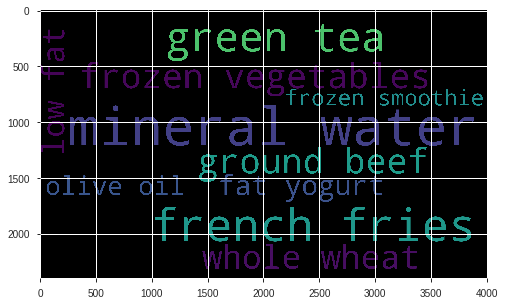

In [17]:
get_word_cloud(data, top=10)

## Reference
[1. association-rules-apriori-algorithm-tutorial](https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html)

[2. apyori](https://github.com/ymoch/apyori)

[3. mlxtend](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)

[4. word_cloud](http://amueller.github.io/word_cloud/)

[5. https://www.kaggle.com/zhangwx95/marketbasket-analysis](https://www.kaggle.com/zhangwx95/marketbasket-analysis)

[6. https://www.kaggle.com/kks96500/apriori-model](https://www.kaggle.com/kks96500/apriori-model)

[7. https://www.kaggle.com/yugagrawal95/market-basket-analysis-apriori-in-python](https://www.kaggle.com/yugagrawal95/market-basket-analysis-apriori-in-python)